In [4]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

RANDOM_SEED = 42

# Specify each path

In [5]:
dataset = 'model/point_history_classifier/point_history.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier.keras'

# Classification number setting

In [6]:
NUM_CLASSES = 5

# input length

In [7]:
TIME_STEPS = 16
DIMENSION = 2

# Load learning data

In [8]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [9]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [11]:
use_lstm = False
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [12]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                250       
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
Total params: 1,097
Trainable params: 1,097
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Model Checkpoint Callbacks
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path.replace('.hdf5', '.keras'), verbose=1, save_weights_only=False)
# Early Abort Callback
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [14]:
# model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# model training

In [15]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
25/32 [======================>.......] - ETA: 0s - loss: 1.5874 - accuracy: 0.2234 
Epoch 1: saving model to model/point_history_classifier\point_history_classifier.keras
32/32 [==============================] - 1s 15ms/step - loss: 1.5824 - accuracy: 0.2269 - val_loss: 1.5601 - val_accuracy: 0.2258
Epoch 2/1000
22/32 [===================>..........] - ETA: 0s - loss: 1.5491 - accuracy: 0.2450
Epoch 2: saving model to model/point_history_classifier\point_history_classifier.keras
32/32 [==============================] - 0s 5ms/step - loss: 1.5413 - accuracy: 0.2475 - val_loss: 1.5221 - val_accuracy: 0.2243
Epoch 3/1000
21/32 [==================>...........] - ETA: 0s - loss: 1.5128 - accuracy: 0.2485
Epoch 3: saving model to model/point_history_classifier\point_history_classifier.keras
32/32 [==============================] - 0s 5ms/step - loss: 1.5071 - accuracy: 0.2506 - val_loss: 1.4841 - val_accuracy: 0.1986
Epoch 4/1000
24/32 [=====================>........] - ETA: 0s 

In [16]:
# Model Save and Load with Proper Configuration
def save_and_load_model(model, save_path):
    """Save and load model with proper configuration"""
    # Save with full configuration
    model.save(save_path, 
              include_optimizer=True,
              save_format='tf')
    
    # Load model and ensure it's compiled
    loaded_model = tf.keras.models.load_model(save_path)
    
    # Verify model is compiled
    if not loaded_model.optimizer:
        loaded_model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
    
    return loaded_model

# Use the function to save and load model
model = save_and_load_model(model, model_save_path)

In [17]:
# Loading a saved model
model = tf.keras.models.load_model(model_save_path)

In [18]:
# Ensure model is properly loaded and compiled
if not model.optimizer:
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

In [19]:
# Reasoning test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 90ms/step
[9.2019004e-01 2.8907236e-02 2.3644427e-02 2.7208127e-02 5.0146220e-05]
0


# Mixed rows

42/42 [==============================] - 0s 1ms/step


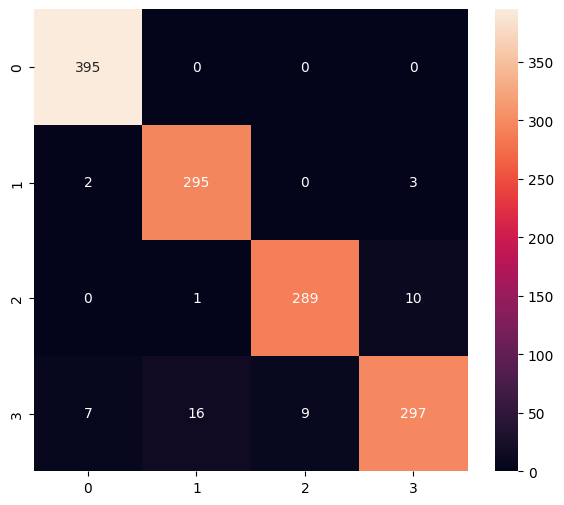

Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       395
           1       0.95      0.98      0.96       300
           2       0.97      0.96      0.97       300
           3       0.96      0.90      0.93       329

    accuracy                           0.96      1324
   macro avg       0.96      0.96      0.96      1324
weighted avg       0.96      0.96      0.96      1324



In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

Visualization

1/1 [==============================] - 0s 25ms/step


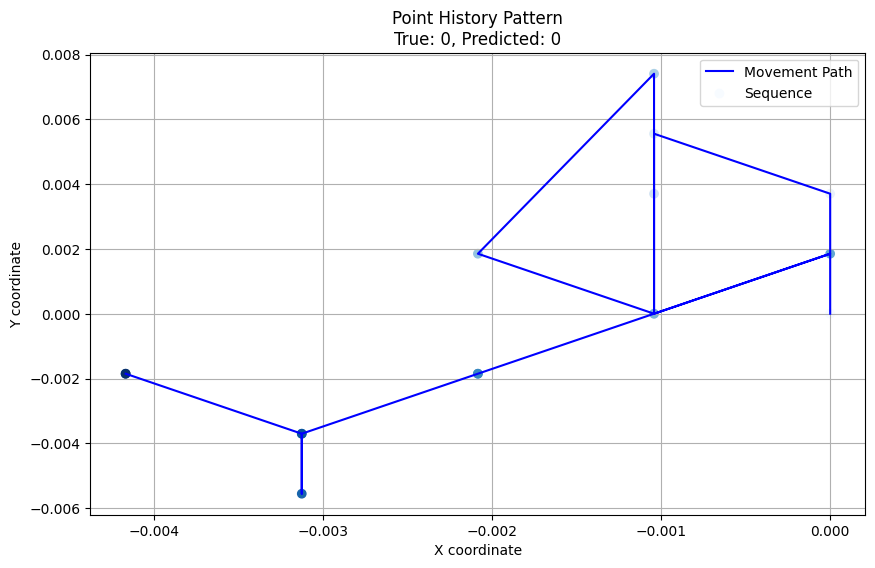

1/1 [==============================] - 0s 23ms/step


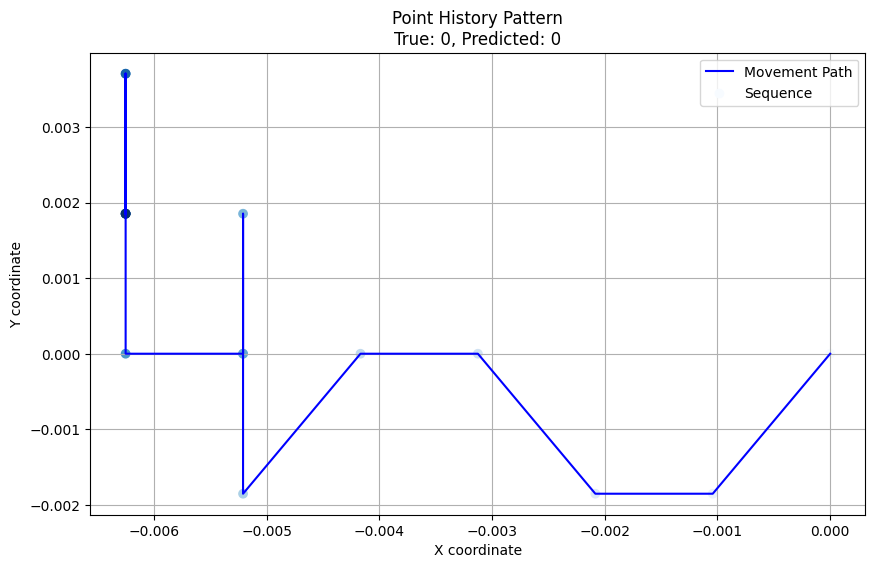

1/1 [==============================] - 0s 24ms/step


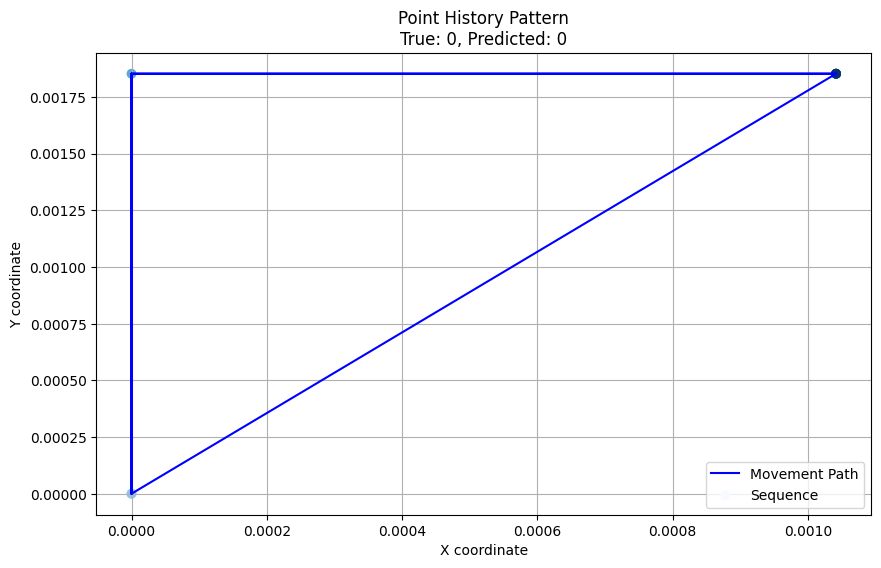

1/1 [==============================] - 0s 24ms/step


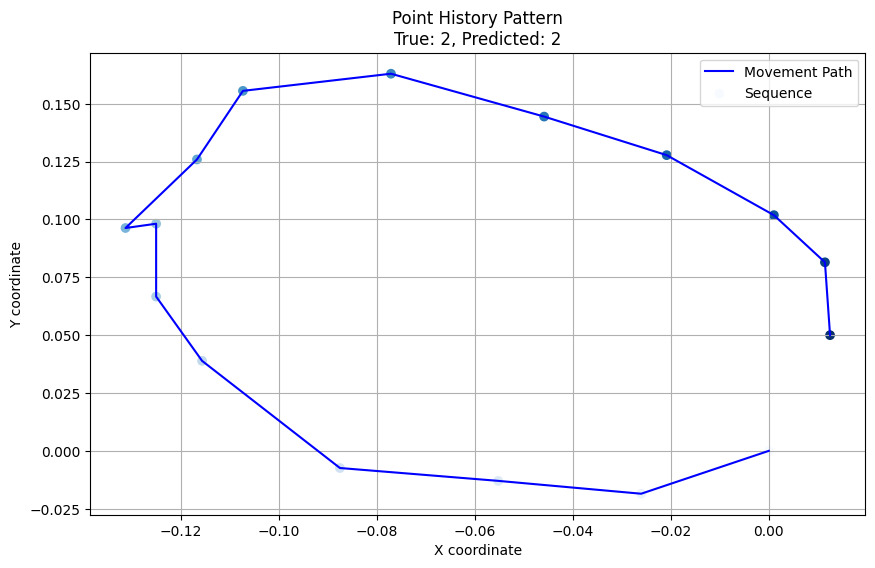

1/1 [==============================] - 0s 23ms/step


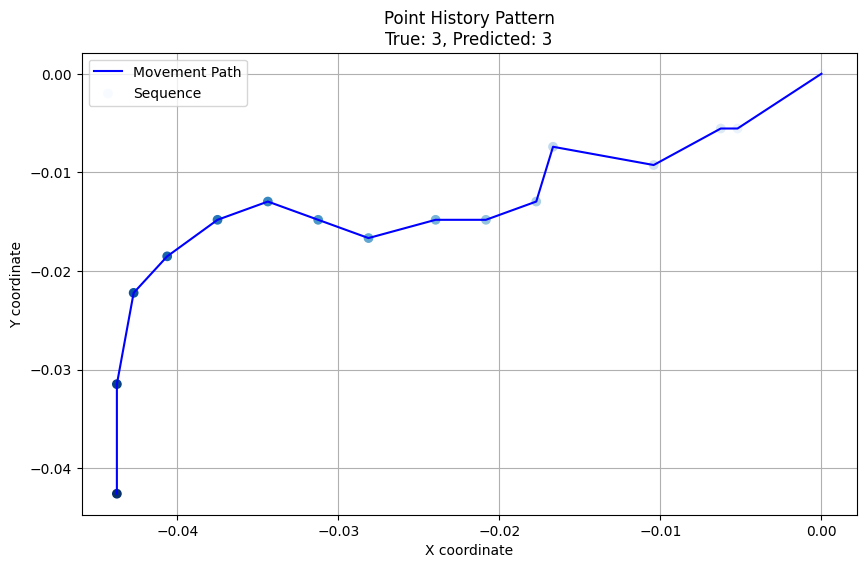

In [21]:
def visualize_point_history(X_test_sample, y_true, y_pred):
    """Visualize point history movement pattern"""
    plt.figure(figsize=(10, 6))
    
    # Reshape data back to temporal sequence
    points = X_test_sample.reshape(-1, 2)  # Reshape to (TIME_STEPS, 2)
    
    # Plot movement pattern
    plt.plot(points[:, 0], points[:, 1], 'b-', label='Movement Path')
    plt.scatter(points[:, 0], points[:, 1], c=np.arange(len(points)), 
                cmap='Blues', label='Sequence')
    
    plt.title(f'Point History Pattern\nTrue: {y_true}, Predicted: {y_pred}')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.legend()
    plt.grid(True)
    plt.show()

# Add after prediction
for i in range(5):  # Show first 5 examples
    y_pred = np.argmax(model.predict(np.array([X_test[i]])))
    visualize_point_history(X_test[i], y_test[i], y_pred)

Movement pattern analysis

42/42 [==============================] - 0s 1ms/step


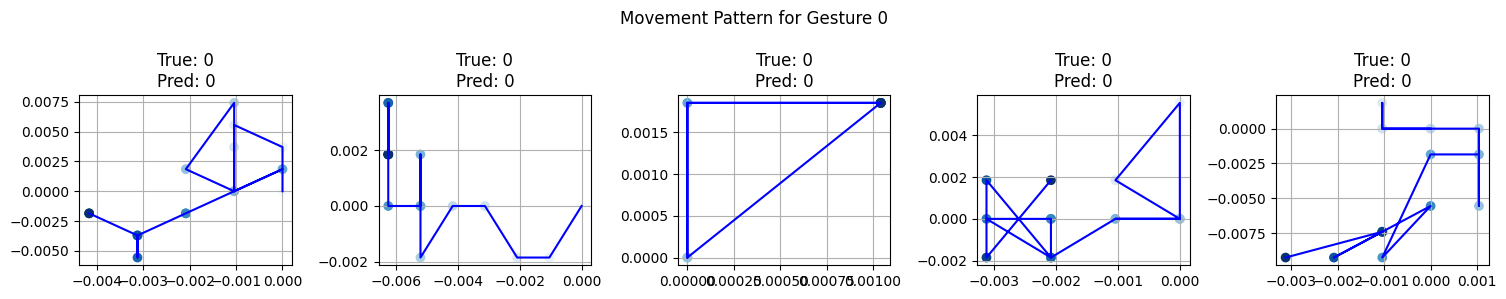

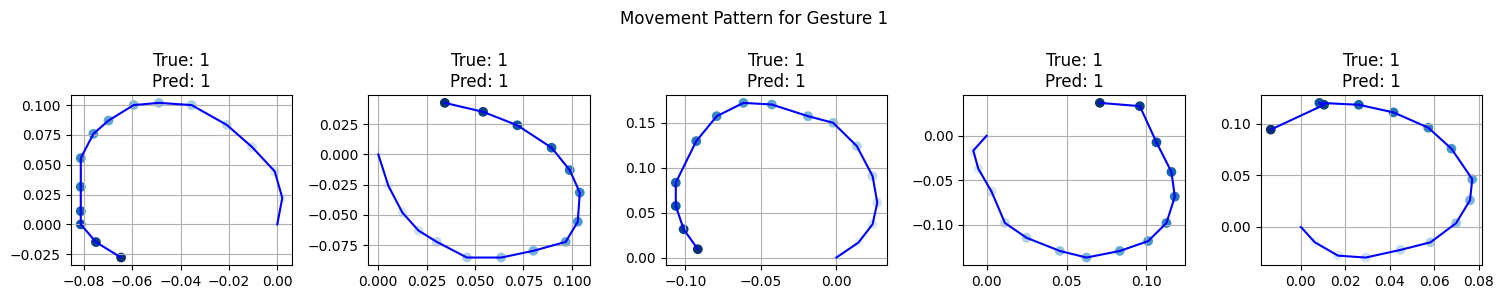

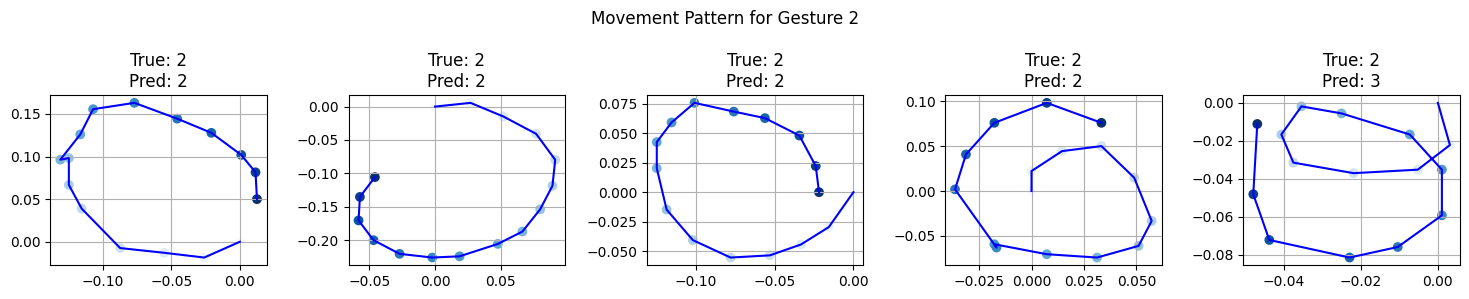

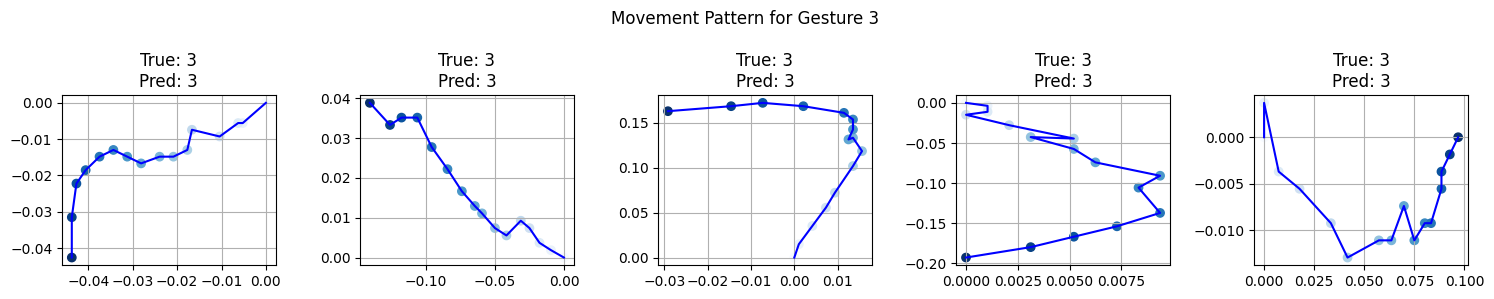

In [22]:
def analyze_movement_patterns(X_test, y_test, y_pred, labels):
    """Analyze different movement patterns"""
    
    # Create figure for each gesture type
    for gesture_id in range(NUM_CLASSES):
        # Get samples for this gesture
        mask = y_test == gesture_id
        samples = X_test[mask][:5]  # Get first 5 samples
        predictions = y_pred[mask][:5]
        
        if len(samples) > 0:
            plt.figure(figsize=(15, 3))
            for idx, (sample, pred) in enumerate(zip(samples, predictions)):
                plt.subplot(1, 5, idx+1)
                points = sample.reshape(-1, 2)
                plt.plot(points[:, 0], points[:, 1], 'b-')
                plt.scatter(points[:, 0], points[:, 1], 
                          c=np.arange(len(points)), cmap='Blues')
                plt.title(f'True: {gesture_id}\nPred: {pred}')
                plt.grid(True)
            plt.suptitle(f'Movement Pattern for Gesture {gesture_id}')
            plt.tight_layout()
            plt.show()

# Add after model evaluation
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

# Load gesture labels
labels = []
with open('model/point_history_classifier/point_history_classifier_label.csv', 
          encoding='utf-8-sig') as f:
    for row in csv.reader(f):
        labels.append(row[0])

analyze_movement_patterns(X_test, y_test, y_pred, labels)

In [23]:
# Verify model configuration before conversion
print("Model Configuration:")
print(f"- Input Shape: {model.input_shape}")
print(f"- Output Shape: {model.output_shape}")
print(f"- Optimizer: {model.optimizer.__class__.__name__}")
print(f"- Loss Function: {model.loss}")
print(f"- Metrics: {model.metrics_names}")

Model Configuration:
- Input Shape: (None, 32)
- Output Shape: (None, 5)
- Optimizer: Adam
- Loss Function: <function sparse_categorical_crossentropy at 0x000001F4E10E83A0>
- Metrics: ['loss', 'accuracy']


# Tensorflow-Lite Convert to Lite model

In [24]:
# Save as an inference-only model
model.save(model_save_path, include_optimizer=True)
model = tf.keras.models.load_model(model_save_path)

In [25]:
tflite_save_path = 'model/point_history_classifier/point_history_classifier.tflite'

In [26]:
# Transform the model (quantize
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Abhis\AppData\Local\Temp\tmpiv10ngd5\assets


INFO:tensorflow:Assets written to: C:\Users\Abhis\AppData\Local\Temp\tmpiv10ngd5\assets


6476

# Reasoning test

In [27]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [28]:
# Get input/output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 32]), 'shape_signature': array([-1, 32]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [29]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [30]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 991 µs


In [31]:
# print(np.squeeze(tflite_results))
# print(np.argmax(np.squeeze(tflite_results)))

Performance analysis

In [32]:
def evaluate_gesture_performance(y_test, y_pred, labels):
    """Evaluate performance for each gesture type"""
    
    print("\nGesture Recognition Performance:")
    print("-" * 40)
    
    # Calculate per-class metrics
    for i, label in enumerate(labels):
        mask = y_test == i
        if np.any(mask):
            accuracy = np.mean(y_test[mask] == y_pred[mask])
            count = np.sum(mask)
            print(f"Gesture '{label}':")
            print(f"  Samples: {count}")
            print(f"  Accuracy: {accuracy:.2%}")
            print("-" * 40)

# Add after predictions
evaluate_gesture_performance(y_test, y_pred, labels)


Gesture Recognition Performance:
----------------------------------------
Gesture 'Stop':
  Samples: 395
  Accuracy: 100.00%
----------------------------------------
Gesture 'Clockwise':
  Samples: 300
  Accuracy: 98.33%
----------------------------------------
Gesture 'Counter Clockwise':
  Samples: 300
  Accuracy: 96.33%
----------------------------------------
Gesture 'Move':
  Samples: 329
  Accuracy: 90.27%
----------------------------------------
